In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)

| Year_Month | Rows |
| :--- | :--- |
| 201608 | 74759 |
| 201609 | 71032 |
| 201610 | 97506 |
| 201611 | 113972 |
| 201612 | 79124 |
| 201701 | 64694 |
| 201702 | 62192 |
| 201703 | 69931 |
| 201704 | 67126 |
| 201705 | 65371 |
| 201706 | 63578 |
| 201707 | 71812|
| 201708 | 2556 |

### Quick view for Google Analytics dataset: 903,653 rows and 16 columns. Size: approximately 30GB
### Tools: BigQuery and Python

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/mengtingke/Desktop/bq_connection.json'

#Initiates BQ service
from google.cloud import bigquery
bigquery_client = bigquery.Client()

#Check Null Value in Each Column
QUERY_NULL = """
SELECT Column_Name, COUNT(1) AS Nulls_Count_Row,
CONCAT(round(100*(count(1)/
                (select count(*)
                FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`)),2),'%') AS Percentage_Nulls_Row
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` t,
UNNEST(REGEXP_EXTRACT_ALL(TO_JSON_STRING(t), r'"(\w+)":null')) Column_Name
GROUP BY Column_Name
ORDER BY Nulls_Count_Row DESC
  """
df_NULL = bigquery_client.query(QUERY_NULL).to_dataframe()
df_NULL

,Column_Name,Nulls_Count_Row,Percentage_Nulls_Row
0,productRefundAmount,18608748,2059.28%
1,localProductRefundAmount,18608748,2059.28%
2,productCouponCode,18608748,2059.28%
3,productRevenue,18571930,2055.21%
4,localProductRevenue,18571930,2055.21%
5,productQuantity,18355178,2031.22%
6,isClick,18162988,2009.95%
7,appName,4153675,459.65%
8,installerId,4153675,459.65%
9,description,4153675,459.65%


### After checking the null value in every column, some columns are totally empty.<br>Beside, some columns have over 100% percentage null value due to <span style="color:green">*nested data column*</span> which means there is more than one data/record in one session/row.<br>To elaborate, imagine in the real world, visitor possibly views more than one product in one session.

<ul>
    <li>Column fully in null value: visitorId, userId, customerId, screenviews, timeOnScreen, etc</li>
    <li>Nested Column: totals, trafficSource, device, geoNetwork, customDimensions, hits</li>
</ul>

***

### Data preprocessing and transforming ↓

In [3]:
#Data preprocessing and transforming. Each session has some unique values, use them to group data
QUERY_ALL = """
SELECT 
ROW_NUMBER() OVER(PARTITION BY fullVisitorId ORDER BY date ASC) AS User_Sequence,
fullVisitorId AS User,
date Date,
TIMESTAMP_SECONDS(VisitStartTime) VisitStartTime,
CONCAT(fullVisitorId, visitId) AS UniqueSessionId,
SUM(IFNULL(Totals.TotalTransactionRevenue, 0))/1000000 AS UniqueSessionId_Revenue,
ROUND(SUM(SUM(IFNULL(Totals.TotalTransactionRevenue, 0))/1000000) OVER(PARTITION BY fullVisitorId ORDER BY date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW), 2) AS User_Accumulate_Revenue,
TrafficSource.Source, TrafficSource.Medium,
Device.DeviceCategory Device, Device.OperatingSystem, Device.Browser,
geoNetwork.Country, geoNetwork.Region State,
CAST(SUM(IFNULL(Totals.Transactions,0)) AS INTEGER) AS Orders, 
CAST(SUM(IFNULL(Totals.hits,0)) AS INTEGER) AS Hits,
CAST(SUM(IFNULL(Totals.PageViews,0)) AS INTEGER) AS PageViews,
CAST(SUM(IFNULL(Totals.Bounces,0)) AS INTEGER) AS Bounces,
CAST(SUM(IFNULL(Totals.Visits,0)) AS INTEGER) AS Visits,
ROUND(SUM(IFNULL(Totals.TimeOnSite, 0))/60,2) AS OnSite_Minutes,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
##WHERE fullVisitorId = '1957458976293878100'
GROUP BY 2,3,4,5,8,9,10,11,12,13,14
"""
df_ALL = bigquery_client.query(QUERY_ALL).to_dataframe()
df_ALL

,User_Sequence,User,Date,VisitStartTime,UniqueSessionId,UniqueSessionId_Revenue,User_Accumulate_Revenue,Source,Medium,Device,OperatingSystem,Browser,Country,State,Orders,Hits,PageViews,Bounces,Visits,OnSite_Minutes
0,1,0000085059828173212,20170719,2017-07-19 22:58:25+00:00,00000850598281732121500505105,0.0,0.0,(direct),(none),mobile,iOS,Safari,United States,Illinois,0,1,1,1,1,0.00
1,1,0000649777500417577,20161102,2016-11-02 18:39:09+00:00,00006497775004175771478111949,0.0,0.0,(direct),(none),tablet,iOS,Safari,Germany,not available in demo dataset,0,6,6,0,1,4.38
2,2,0000649777500417577,20161104,2016-11-04 19:07:39+00:00,00006497775004175771478286459,0.0,0.0,(direct),(none),tablet,iOS,Safari,Germany,not available in demo dataset,0,1,1,1,1,0.00
3,1,0001266240591974276,20170606,2017-06-06 12:47:45+00:00,00012662405919742761496753265,0.0,0.0,google.com,referral,mobile,Android,Chrome,Spain,Community of Madrid,0,115,66,0,1,5.87
4,1,0002388540523328376,20161116,2016-11-16 21:56:38+00:00,00023885405233283761479333398,0.0,0.0,youtube.com,referral,desktop,Windows,Chrome,Turkey,Izmir,0,1,1,1,1,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,1,9996395802162832591,20161230,2016-12-31 04:04:00+00:00,99963958021628325911483157040,0.0,0.0,youtube.com,referral,desktop,Linux,Chrome,India,not available in demo dataset,0,3,3,0,1,4.97
903649,1,9997219040306108466,20160803,2016-08-03 08:45:21+00:00,99972190403061084661470213921,0.0,0.0,youtube.com,referral,desktop,Windows,Chrome,Spain,not available in demo dataset,0,2,2,0,1,2.58
903650,1,9998040283795943621,20170106,2017-01-06 08:39:36+00:00,99980402837959436211483691976,0.0,0.0,(direct),(none),desktop,Windows,Chrome,United States,not available in demo dataset,0,3,3,0,1,0.42
903651,1,9998677794372079396,20161104,2016-11-04 16:03:35+00:00,99986777943720793961478275415,0.0,0.0,youtube.com,referral,desktop,Macintosh,Safari,Vietnam,Da Nang,0,1,1,1,1,0.00


In [4]:
#Convert timestamp to UTC datetime
df_ALL['VisitStartTime'] = pd.to_datetime(df_ALL.VisitStartTime).dt.tz_localize(None)

In [5]:
#Checking record
df_ALL[(df_ALL['User']=='1957458976293878100')&(df_ALL['Date']=='20170630')]

,User_Sequence,User,Date,VisitStartTime,UniqueSessionId,UniqueSessionId_Revenue,User_Accumulate_Revenue,Source,Medium,Device,OperatingSystem,Browser,Country,State,Orders,Hits,PageViews,Bounces,Visits,OnSite_Minutes
683183,267,1957458976293878100,20170630,2017-06-30 13:49:53,19574589762938781001498830593,1205.74,128412.52,dfa,cpm,desktop,Windows,Firefox,United States,not available in demo dataset,1,42,30,0,1,16.7


In [6]:
df_ALL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   User_Sequence            903653 non-null  Int64         
 1   User                     903653 non-null  object        
 2   Date                     903653 non-null  object        
 3   VisitStartTime           903653 non-null  datetime64[ns]
 4   UniqueSessionId          903653 non-null  object        
 5   UniqueSessionId_Revenue  903653 non-null  float64       
 6   User_Accumulate_Revenue  903653 non-null  float64       
 7   Source                   903653 non-null  object        
 8   Medium                   903653 non-null  object        
 9   Device                   903653 non-null  object        
 10  OperatingSystem          903653 non-null  object        
 11  Browser                  903653 non-null  object        
 12  Country         

In [7]:
#Calculating total revenue and counting session for each user
temp = df_ALL.groupby('User')['User_Accumulate_Revenue','User_Sequence'].agg('max').reset_index().sort_values(['User_Accumulate_Revenue','User_Sequence'],ascending=False)
temp

<ipython-input-7-1df6e8ffca44>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = df_ALL.groupby('User')['User_Accumulate_Revenue','User_Sequence'].agg('max').reset_index().sort_values(['User_Accumulate_Revenue','User_Sequence'],ascending=False)


,User,User_Accumulate_Revenue,User_Sequence
139589,1957458976293878100,128412.52,278
672547,9417857471295131045,41810.85,16
401727,5632276788326171571,16032.75,6
318933,4471415710206918415,11229.10,34
649241,9089132392240687728,10041.75,22
...,...,...,...
714161,9999955365228667450,0.00,1
714162,9999963186378918199,0.00,1
714163,999997225970956660,0.00,1
714165,9999978264901065827,0.00,1


<AxesSubplot:xlabel='User_Accumulate_Revenue', ylabel='Count'>

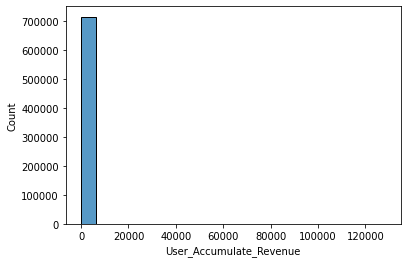

In [8]:
sns.histplot(data=temp, x="User_Accumulate_Revenue")

/Users/mengtingke/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:454: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges[:-1], name="edges"),
/Users/mengtingke/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:455: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(np.diff(edges) * shrink, name="widths"),


<AxesSubplot:xlabel='User_Sequence', ylabel='Count'>

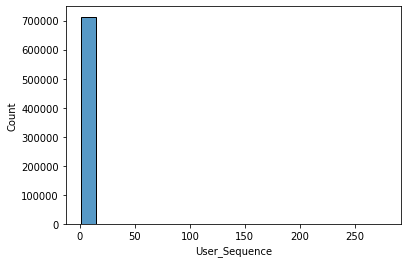

In [9]:
sns.histplot(data=temp, x="User_Sequence")

In [10]:
len(temp[temp['User_Accumulate_Revenue']>0])

9996

In [11]:
len(temp[temp['User_Accumulate_Revenue']==0])

704171

In [12]:
#617555 out of 704171 doesn't purchase and only has one session
temp[temp['User_Accumulate_Revenue']==0].groupby(['User_Sequence'])[['User']].count().reset_index().rename(columns={'User': 'Count'}).head()

,User_Sequence,Count
0,1,617555
1,2,56453
2,3,15691
3,4,6462
4,5,3022


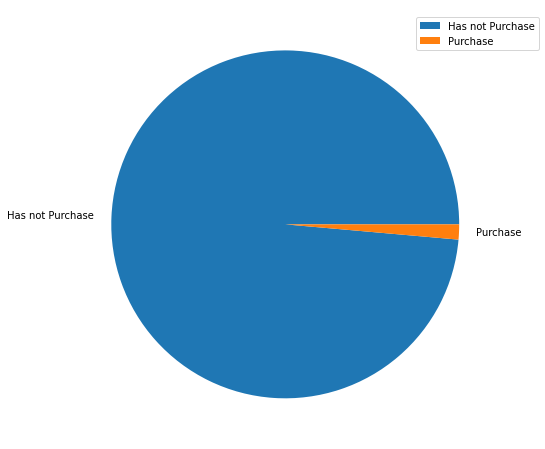

In [13]:
plt.figure(figsize=(8, 8))
plt.pie(np.array([704171, 9996]), labels = ['Has not Purchase','Purchase'])
plt.legend(loc =(0.8, 0.9))
plt.show()

### There are 714,167 unique users access to Google Merchandise Store website between 2016/08/01 and 2017/08/01 in 903,653 sessions. Only <span style="color:green">*9,996 users(1.4% of all users) make orders*</span>, while the rest 704,171 users hasn't purchase anything from website yet.
### <span style="color:green">87.7% of users has only one session and hasn't make any order in the period</span>.
***

In [14]:
temp['User_Accumulate_Revenue'].sum()

1780149.23

In [15]:
AOV = temp['User_Accumulate_Revenue'].sum()/9996
AOV

178.0861574629852

### Total Revenue is \\$1780149.23. Average Order Value (AOV) is $178.09

### Question: AOV is around \\$180, how does people spend over \\$5,000 in a year? How does user 3924372865099736100 spend \\$9,227 in one and the only session? Theses record seems to be outliers.

***
### Country ↓

In [16]:
QUERY_COUNTRY = """
SELECT Temp.country, Temp.Count_Purchased_Session, Temp2.Count_NONpurchased_Session, 
(Temp.Count_Purchased_Session + Temp2.Count_NONpurchased_Session) As TotalSession_Country
FROM
(
SELECT geonetwork.country, count(*) AS Count_Purchased_Session
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
where totals.transactionrevenue IS NOT NULL 
GROUP by geonetwork.country
ORDER BY Count_Purchased_Session DESC
)TEMP
LEFT JOIN(
SELECT geonetwork.country, count(*) AS Count_NONpurchased_Session
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
where totals.transactionRevenue IS Null 
GROUP by geonetwork.country
ORDER BY Count_NONpurchased_Session DESC
)TEMP2
ON TEMP.country = TEMP2.country
ORDER BY TotalSession_Country DESC
"""

df_country = bigquery_client.query(QUERY_COUNTRY).to_dataframe()
df_country

,country,Count_Purchased_Session,Count_NONpurchased_Session,TotalSession_Country
0,United States,10953,353791,364744
1,India,10,51130,51140
2,United Kingdom,16,37377,37393
3,Canada,190,25679,25869
4,Turkey,2,20520,20522
5,Thailand,5,20118,20123
6,Germany,8,19972,19980
7,Brazil,10,19773,19783
8,Japan,17,19714,19731
9,France,5,15827,15832


In [17]:
df_country['Percentage_Purchased_Session'] = ((df_country['Count_Purchased_Session'] / df_country['Count_Purchased_Session'].sum()) * 100)\
                                                .round(2).astype(str) + '%'
df_country['Percentage_NONpurchased_Session'] = ((df_country['Count_NONpurchased_Session'] / df_country['Count_NONpurchased_Session'].sum()) * 100)\
                                                .round(2).astype(str) + '%'
df_country['Percentage_TotalSession_Country'] = ((df_country['TotalSession_Country'] / df_country['TotalSession_Country'].sum()) * 100)\
                                                .round(2).astype(str) + '%'

In [18]:
df_country

,country,Count_Purchased_Session,Count_NONpurchased_Session,TotalSession_Country,Percentage_Purchased_Session,Percentage_NONpurchased_Session,Percentage_TotalSession_Country
0,United States,10953,353791,364744,95.12%,42.77%,43.49%
1,India,10,51130,51140,0.09%,6.18%,6.1%
2,United Kingdom,16,37377,37393,0.14%,4.52%,4.46%
3,Canada,190,25679,25869,1.65%,3.1%,3.08%
4,Turkey,2,20520,20522,0.02%,2.48%,2.45%
5,Thailand,5,20118,20123,0.04%,2.43%,2.4%
6,Germany,8,19972,19980,0.07%,2.41%,2.38%
7,Brazil,10,19773,19783,0.09%,2.39%,2.36%
8,Japan,17,19714,19731,0.15%,2.38%,2.35%
9,France,5,15827,15832,0.04%,1.91%,1.89%


### I find that <span style="color:green">*US*</span> is the main market with a 43.49% of all session and 95.12% of orders order from US. India, ranked second, has only 6.1% of all session which is way far behind US.
***
### Source ↓

In [19]:
QUERY_TRAFFIC = """
SELECT S1.source,All_Occurrence, Purchased_Occurrence
FROM
(
SELECT trafficSource.Source,count(trafficSource.Source) AS All_Occurrence
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP by trafficSource.Source
) S1
LEFT JOIN
(
SELECT trafficSource.Source,count(trafficSource.Source) AS Purchased_Occurrence
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE totals.transactions = 1
GROUP by trafficSource.Source
) S2
ON S1.Source = S2.Source
ORDER BY All_Occurrence DESC
"""
df_traffic = bigquery_client.query(QUERY_TRAFFIC).to_dataframe()
df_traffic.head(10)

,source,All_Occurrence,Purchased_Occurrence
0,(direct),371469,8471
1,google,241280,2273
2,youtube.com,212602,11
3,Partners,16411,9
4,analytics.google.com,16172,<NA>
5,dfa,5686,118
6,google.com,4669,5
7,m.facebook.com,3365,5
8,baidu,3356,<NA>
9,sites.google.com,2983,41


### Top 3 source : (direct), google, youtube.com.
### While <span style="color:green">*youtube.com*</span> come with bad conversion rate, user possibly click ad link to get access to Google Merchandise Store but hasn't purchase in the end. I consider the practical senario might be the ad was mistaked click by the user before the video play.
***
### Youtube_Country ↓

In [20]:
QUERY_YT_TRAFFIC = """
SELECT trafficSource.source Source, geoNetwork.Country Country,count(*) Count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE trafficSource.source LIKE '%youtube%'
GROUP by trafficSource.source, geoNetwork.Country
ORDER BY Count DESC
"""
df_yt_traffic = bigquery_client.query(QUERY_YT_TRAFFIC).to_dataframe()
df_yt_traffic.head(10)

,Source,Country,Count
0,youtube.com,Vietnam,21831
1,youtube.com,United States,18710
2,youtube.com,Thailand,17069
3,youtube.com,Turkey,16599
4,youtube.com,India,13592
5,youtube.com,Brazil,12865
6,youtube.com,Mexico,7839
7,youtube.com,Russia,6742
8,youtube.com,Japan,5495
9,youtube.com,Philippines,4663


### Perhaps Google should consider not to advertise on the platform.
***
### Browser ↓

In [21]:
QUERY_BROWSER = """
SELECT S1.browser Browser, All_Occurrence, Purchased_Occurrence
FROM
(
SELECT device.browser,count(device.browser) AS All_Occurrence
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP by device.browser
) S1
LEFT JOIN
(
SELECT device.browser,count(device.browser) AS Purchased_Occurrence
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE totals.transactions = 1
GROUP by device.browser
) S2
ON S1.browser = S2.browser
ORDER BY All_Occurrence DESC
"""
df_browser = bigquery_client.query(QUERY_BROWSER).to_dataframe()
df_browser.head(10)

,Browser,All_Occurrence,Purchased_Occurrence
0,Chrome,620364,10044
1,Safari,182245,779
2,Firefox,37069,185
3,Internet Explorer,19375,111
4,Edge,10205,57
5,Android Webview,7865,6
6,Safari (in-app),6850,12
7,Opera Mini,6139,<NA>
8,Opera,5643,4
9,UC Browser,2427,<NA>


### As a dominant browser, <span style="color:green">*Chrome*</span>  ranks top one in no doubt.
***
### Revenue and Gross Profit by products ↓

In [22]:
QUERY_PRODUCT = """
SELECT
ROUND(SUM(IFNULL(p.productRevenue, 0)/1000000),2) AS TotalProductRevenue,
ROUND(SUM(IFNULL(p.productPrice, 0)/1000000),2) AS TotalProductPrice,
CAST(SUM(IFNULL(p.productQuantity,0)) AS INTEGER) AS TotalProductQuantity,
p.v2ProductName ProductName,p.v2ProductCategory ProductCategory,
COUNT(h.hitNumber) HitTime,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
UNNEST(hits) AS h,
UNNEST(h.product) AS p
GROUP BY ProductCategory, ProductName
ORDER BY TotalProductRevenue DESC
"""
df_product = bigquery_client.query(QUERY_PRODUCT).to_dataframe()
df_product.head(15)

,TotalProductRevenue,TotalProductPrice,TotalProductQuantity,ProductName,ProductCategory,HitTime
0,35395.21,201382.27,44675,Google 22 oz Water Bottle,Drinkware,4997
1,34684.93,161434.71,2030,Google Men's Zip Hoodie,Apparel,2892
2,33455.32,148956.99,4913,26 oz Double Wall Insulated Bottle,Drinkware,2219
3,29855.04,101027.85,10393,Leatherette Journal,Office,1433
4,29526.77,159707.86,32117,Google Sunglasses,Lifestyle,8405
5,24936.45,138585.31,21252,Recycled Paper Journal Set,Office,3157
6,22136.81,177165.88,6721,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,4561
7,20972.21,93212.07,12590,Sport Bag,Bags,1703
8,20240.30,83290.92,3845,Google 17oz Stainless Steel Sport Bottle,Drinkware,1445
9,20009.07,127876.19,4341,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,4805


In [23]:
#Some products are not sold at all  (Some products sold over but hasn't have revenue?! Seems like dirty data)
df_product.tail(10)

,TotalProductRevenue,TotalProductPrice,TotalProductQuantity,ProductName,ProductCategory,HitTime
4397,0.0,44.95,0,Android Journal Book Set,Home/Brands/,5
4398,0.0,155.94,2,Google Youth Tee Fruit Games Banana,${escCatTitle},6
4399,0.0,72.16,67,Android Women's Short Sleeve Badge Tee Light C...,${escCatTitle},4
4400,0.0,38.38,2,Android 24 oz Contigo Bottle,${productitem.product.origCatName},1
4401,0.0,119.99,0,Men's Lotus H2X Dry Full Zip Jacket,Home/Apparel/Men's/Men's-Outerwear/,1
4402,0.0,75.96,3,YouTube Women's Short Sleeve Crew Tee,Apparel,4
4403,0.0,0.00,0,Android Men's Skater Badge Tee Charcoal,Shop by Brand/Android/,1
4404,0.0,19.99,0,Android BTTF Cosmos Graphic Tee,/Shop by Brand/Android/,1
4405,0.0,0.00,0,Rowan Pullover Hood,Mens Outerwear,1
4406,0.0,19.99,0,Android Men's Engineer Short Sleeve Tee Charcoal,Home/Shop by Brand/,1


In [24]:
df_product.groupby(['ProductCategory']).sum().reset_index().sort_values(['TotalProductRevenue'],ascending = False).head(20)

,ProductCategory,TotalProductRevenue,TotalProductPrice,TotalProductQuantity,HitTime
8,Apparel,517059.87,3855848.55,91463,110283
2,(not set),331961.49,11816327.14,479113,1001096
96,Office,259126.53,1340970.88,282383,45147
13,Drinkware,180279.66,913944.32,86141,24182
10,Bags,121924.19,718801.33,40325,12488
14,Electronics,95626.48,588344.07,32499,11171
87,Lifestyle,65368.15,405164.49,71331,17906
95,Notebooks & Journals,65262.65,185196.42,20617,2935
19,Headgear,32275.93,137407.32,7539,5071
1,${productitem.product.origCatName},16008.08,122708.72,8314,2784


In [25]:
product = df_product[~((df_product['TotalProductRevenue']==0) | (df_product['TotalProductQuantity']==0))]
product['Percentage_TotalRevenue'] = ((product['TotalProductRevenue'] / product['TotalProductRevenue'].sum()) * 100)
product

<ipython-input-25-b3ea168681e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product['Percentage_TotalRevenue'] = ((product['TotalProductRevenue'] / product['TotalProductRevenue'].sum()) * 100)


,TotalProductRevenue,TotalProductPrice,TotalProductQuantity,ProductName,ProductCategory,HitTime,Percentage_TotalRevenue
0,35395.21,201382.27,44675,Google 22 oz Water Bottle,Drinkware,4997,2.031817
1,34684.93,161434.71,2030,Google Men's Zip Hoodie,Apparel,2892,1.991045
2,33455.32,148956.99,4913,26 oz Double Wall Insulated Bottle,Drinkware,2219,1.920460
3,29855.04,101027.85,10393,Leatherette Journal,Office,1433,1.713791
4,29526.77,159707.86,32117,Google Sunglasses,Lifestyle,8405,1.694947
...,...,...,...,...,...,...,...
940,4.65,31.84,6,8 pc Android Sticker Sheet,${productitem.product.origCatName},9,0.000267
941,4.12,27.06,8,Google Badge Pull,Office,11,0.000237
942,3.93,932.61,614,Google Doodle Decal,(not set),457,0.000226
943,3.00,231.70,39,Google Sunglasses Green,Lifestyle,20,0.000172


In [26]:
product['RevenuePerProduct'] = round(product['TotalProductRevenue']/product['TotalProductQuantity'],2)

<ipython-input-26-f0f65b829797>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product['RevenuePerProduct'] = round(product['TotalProductRevenue']/product['TotalProductQuantity'],2)


In [27]:
product.sort_values(['RevenuePerProduct'],ascending = False).head(10)

,TotalProductRevenue,TotalProductPrice,TotalProductQuantity,ProductName,ProductCategory,HitTime,Percentage_TotalRevenue,RevenuePerProduct
465,542.65,2626.10,11,Google Phone Sanitizer,Electronics,27,0.031150,49.33
355,1049.07,6859.40,23,Google Women's Zip Hoodie Grey,Apparel,60,0.060221,45.61
528,359.26,2063.74,10,Women's Performance Full Zip Jacket Black,${productitem.product.origCatName},15,0.020623,35.93
493,455.94,41281.95,14,Digital Lightshow Smart Speaker and Notificati...,(not set),771,0.026173,32.57
170,2548.00,17300.00,79,Gift Card- $100.00,Gift Cards,173,0.146265,32.25
658,170.97,615.89,6,Android Men's Zip Hoodie,Apparel,5,0.009814,28.5
434,680.59,11498.72,24,Oasis Backpack,(not set),463,0.039068,28.36
364,1020.50,23250.00,37,Gift Card - $250.00,Gift Cards,89,0.058581,27.58
133,3219.46,22129.73,117,Google Women's 1/4 Zip Jacket Charcoal,Apparel,239,0.184809,27.52
394,832.40,7583.24,31,Google Women's Insulated Thermal Vest Navy,Apparel,64,0.047783,26.85


In [28]:
product.sort_values(['TotalProductRevenue','RevenuePerProduct'],ascending = False).head(10)

,TotalProductRevenue,TotalProductPrice,TotalProductQuantity,ProductName,ProductCategory,HitTime,Percentage_TotalRevenue,RevenuePerProduct
0,35395.21,201382.27,44675,Google 22 oz Water Bottle,Drinkware,4997,2.031817,0.79
1,34684.93,161434.71,2030,Google Men's Zip Hoodie,Apparel,2892,1.991045,17.09
2,33455.32,148956.99,4913,26 oz Double Wall Insulated Bottle,Drinkware,2219,1.920460,6.81
3,29855.04,101027.85,10393,Leatherette Journal,Office,1433,1.713791,2.87
4,29526.77,159707.86,32117,Google Sunglasses,Lifestyle,8405,1.694947,0.92
5,24936.45,138585.31,21252,Recycled Paper Journal Set,Office,3157,1.431445,1.17
6,22136.81,177165.88,6721,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,4561,1.270736,3.29
7,20972.21,93212.07,12590,Sport Bag,Bags,1703,1.203883,1.67
8,20240.30,83290.92,3845,Google 17oz Stainless Steel Sport Bottle,Drinkware,1445,1.161869,5.26
9,20009.07,127876.19,4341,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,4805,1.148595,4.61


In [29]:
product.groupby(['ProductCategory']).sum().reset_index().sort_values(['TotalProductRevenue','RevenuePerProduct'],ascending = False).head(10)

,ProductCategory,TotalProductRevenue,TotalProductPrice,TotalProductQuantity,HitTime,Percentage_TotalRevenue,RevenuePerProduct
4,Apparel,517059.87,3855580.67,91456,110277,29.681168,1529.55
1,(not set),331961.49,10340078.39,472025,836392,19.055830,1543.14
18,Office,259126.53,1340970.88,282383,45147,14.874831,157.45
8,Drinkware,180279.66,913933.93,86140,24001,10.348726,111.06
6,Bags,121924.19,718801.33,40325,12488,6.998904,117.04
9,Electronics,95626.48,588344.07,32499,11171,5.489317,266.47
15,Lifestyle,65368.15,405164.49,71331,17906,3.752376,43.05
17,Notebooks & Journals,65262.65,185196.42,20617,2935,3.746320,36.99
13,Headgear,32275.93,137407.32,7539,5071,1.852759,80.92
0,${productitem.product.origCatName},16008.08,97873.07,7658,2407,0.918924,638.37


### Top 5 total earning category : Appareal, (not set), Office, Drinkware, Bags.
### Top 3 total product revenue : Google 22 oz Water Bottle, Google Men's Zip Hoodie, 26 oz Double Wall Insulated Bottle.
### Top 3 gross profit : Google Phone Sanitizer, Google Women's Zip Hoodie Grey, Women's Performance Full Zip Jacket Black.
### According to the result, I find that <span style="color:green">*Apparel category*</span> plays a critical role in whole performance with both highly rank of total revenue and gross profit metric.
***
### Transaction by hour ↓

In [30]:
QUERY_HOUR = """
SELECT H1.AllSessionHour,ASH_COUNT,TH_COUNT
FROM
(
SELECT 
EXTRACT(HOUR FROM TIMESTAMP_SECONDS(VisitStartTime)) AS AllSessionHour,
COUNT(*) AS ASH_Count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
GROUP BY AllSessionHour
) H1
LEFT JOIN
(
SELECT 
EXTRACT(HOUR FROM TIMESTAMP_SECONDS(VisitStartTime)) AS TransactionHour,
COUNT(*) AS TH_Count
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE totals.transactions = 1
GROUP BY TransactionHour
) H2
ON H1.AllSessionHour = H2.TransactionHour
ORDER BY H1.AllSessionHour ASC
"""

df_hour = bigquery_client.query(QUERY_HOUR).to_dataframe()
df_hour['TH_Percentage'] = df_hour['TH_COUNT']/df_hour['ASH_COUNT']
df_hour

,AllSessionHour,ASH_COUNT,TH_COUNT,TH_Percentage
0,0,33482,575,0.017173
1,1,32512,486,0.014948
2,2,32063,472,0.014721
3,3,31235,386,0.012358
4,4,29942,378,0.012624
5,5,29584,281,0.009498
6,6,29696,133,0.004479
7,7,31121,109,0.003502
8,8,30889,74,0.002396
9,9,30184,45,0.001491


<AxesSubplot:xlabel='AllSessionHour', ylabel='ASH_COUNT'>

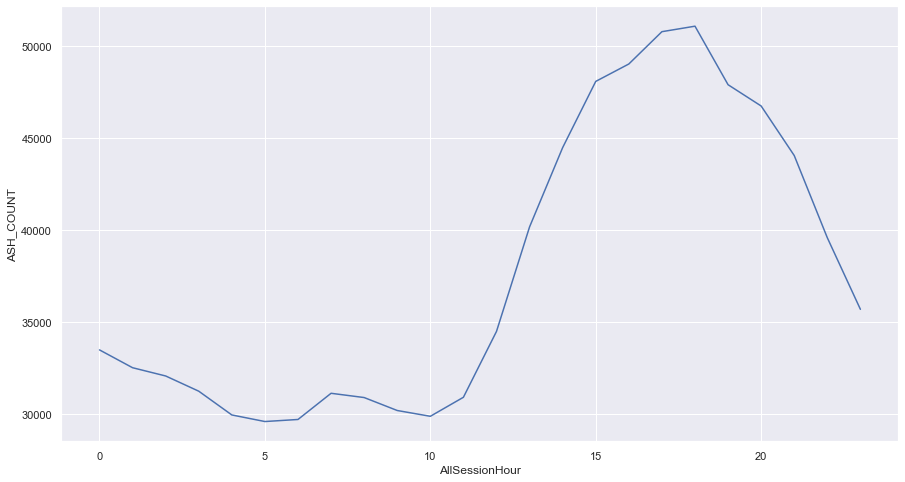

In [31]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data = df_hour, x="AllSessionHour", y="ASH_COUNT")

<AxesSubplot:xlabel='AllSessionHour', ylabel='TH_COUNT'>

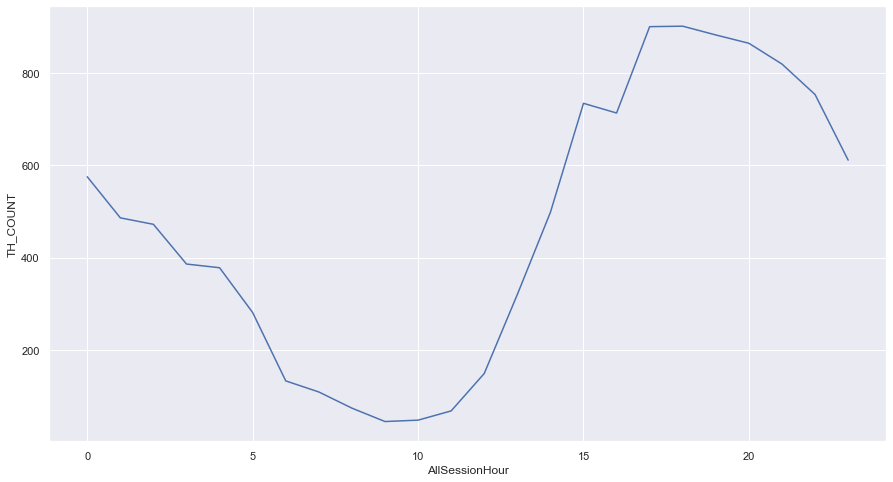

In [32]:
sns.lineplot(data = df_hour, x="AllSessionHour", y="TH_COUNT")

<AxesSubplot:xlabel='AllSessionHour', ylabel='TH_Percentage'>

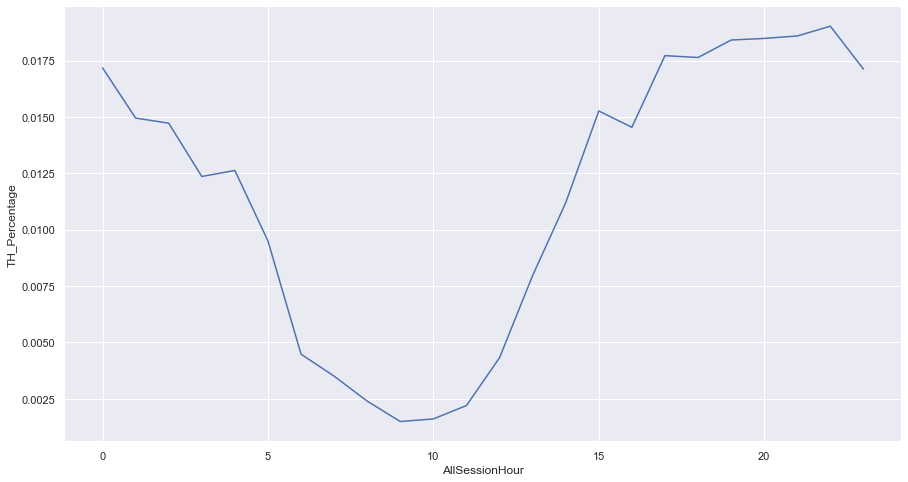

In [33]:
sns.lineplot(data = df_hour, x="AllSessionHour", y="TH_Percentage")

### After plotting hour data, find out <span style="color:green">*15pm\~21pm in UTC time zone, which is 8am\~14pm in Pacific Time or 11am\~17pm Eastern Time*</span> is peak time for both viewing and ordering.

### In this task, I am working on a brief EDA through Google Analytics Dataset, while there are more things could dive into including State, productRefundAmount, action on product page (hits.eCommerceAction.action_type), etc.